In [135]:
import torch
from torch import nn
from dpk import model_objs

class Reshape(nn.Module): 
    def __init__(self, shape): 
        super(Reshape, self).__init__() 
        self.shape = shape 
    
    def forward(self, x): 
        return x.view(self.shape)

class ConvAutoEncoder(torch.nn.Module):
    
    def __init__(self, bottleneck_chans=8, bottleneck_dim=72, map_path=".\\data\\map."):
        
        super(ConvAutoEncoder, self).__init__()
        # assert bottleneck_dim in {2, 8, 18, 32, 50, 72, 98, 128, 162, 200, 242, 288}  # must be twice a square number
        # sqrt = int(np.round((bottleneck_dim / 2) ** 0.5))
        self.bottleneck_chans = bottleneck_chans
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=2, kernel_size=4, stride=4, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=2, out_channels=3, kernel_size=4, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=4, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=4, out_channels=bottleneck_chans, kernel_size=4, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Flatten(start_dim=1, end_dim=-1),
                                    nn.Linear(in_features=13 * 6 * bottleneck_chans, out_features=bottleneck_dim),  # this must be changed if the above is modified
                                    nn.Tanh()
        )
        
        self.decoder1 = nn.Sequential(nn.Linear(in_features=bottleneck_dim, out_features=13 * 6 * bottleneck_chans),
                                    Reshape((1, self.bottleneck_chans, 13, 6)),
                                    nn.ConvTranspose2d(in_channels=bottleneck_chans, out_channels=8, kernel_size=4, stride=3, padding=2),
                                    nn.Tanh(),
                                    nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=4, padding=2),
                                    nn.Tanh())
        self.map = torch.load(map_dir)
        self.decoder2 = 
                                    nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=4, stride=4, padding=2),
                                    nn.Tanh(),
                                    nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=4, stride=4, padding=2),
                                    nn.Tanh()
        )

    def forward(self, data):
        encoding = self.encoder(data)
        x = self.decoder_linear(encoding)
        return self.decoder(encoding)




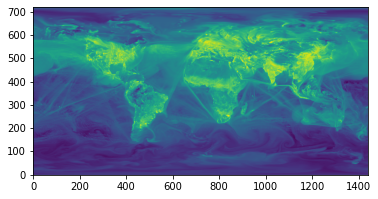

In [212]:
import xarray as xr
import matplotlib.pyplot as plt

def get_data(path):
    data = xr.open_dataset(path)
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    darr = torch.tensor(darr)[:, None, :, :]  # shape (t, 1 chan, w, h)
    # darr = torch.transpose(torch.transpose(darr, dim0=0, dim1=2), dim0=0, dim1=1)[None, :, :, :]  # shape (1, w, h, t)
    
    return torch.log(darr + 1e-30)

    
from torch.optim import Adam

data = get_data(r"./data/NO2_" + "2018-01-31" + ".nc4") # 3d tensor of snapshots
plt.imshow(data[0, 0, :, :], origin="lower")

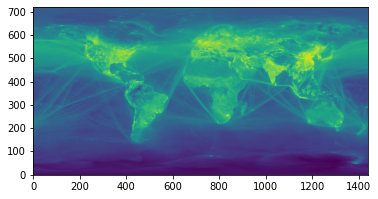

In [217]:
import os

# create map -- the average of 240 random snapshots
# ["2018-01-31", "2018-3-16", "2018-07-21", "2018-10-20", "2018-11-25", "2018-11"]
map = None
files = os.listdir(r"./data/")
for fname in files:
    data = get_data(os.path.join(r"./data/", fname)) # 3d tensor of snapshots
    if map is None:
        map = torch.mean(data, dim=0)
    else:
        map += torch.mean(data, dim=0)
map /= len(files)
plt.imshow(map[0], origin="lower")

In [219]:
torch.save(map, "./data/map.pt")

In [206]:
# reproducibility
seed = 633

print("[ Using Seed : ", seed, " ]")

import torch
import random
import numpy as np
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

batch_size = 8
lr = 1e-7
wd = 1e-5

model = ConvAutoEncoder(bottleneck_chans=16)
opt = Adam(model.parameters(), lr=lr, weight_decay=wd)
epochs = 0

[ Using Seed :  633  ]


In [207]:
for i in range(5):
    for batch in range(data.shape[0] // batch_size):
        opt.zero_grad()
        batch_data = data[batch_size * batch:batch_size * (batch + 1)]
        reconstruction = model(batch_data)[:, :, 50:771, 100:1540]
        error = torch.mean((reconstruction - batch_data) ** 2)
        error.backward()
        print(error.detach())
        opt.step()
    epochs += 1

tensor(625.2979)
tensor(626.5187)
tensor(627.1191)
tensor(625.2978)
tensor(626.5187)
tensor(627.1191)
tensor(625.2977)
tensor(626.5186)
tensor(627.1191)
tensor(625.2977)
tensor(626.5186)
tensor(627.1191)
tensor(625.2977)
tensor(626.5186)
tensor(627.1191)


In [208]:
model(batch_data).shape, batch_data.shape, model.encoder(batch_data)

(torch.Size([8, 1, 876, 2028]),
 torch.Size([8, 1, 721, 1440]),
 tensor([[[[-0.0228, -0.0228, -0.0228,  ..., -0.0228, -0.0228, -0.0228],
           [-0.0228, -0.0228, -0.0228,  ..., -0.0228, -0.0228, -0.0228],
           [-0.0228, -0.0228, -0.0228,  ..., -0.0228, -0.0228, -0.0228],
           [-0.0228, -0.0228, -0.0228,  ..., -0.0228, -0.0228, -0.0228],
           [-0.0228, -0.0228, -0.0228,  ..., -0.0228, -0.0228, -0.0228],
           [-0.0228, -0.0228, -0.0228,  ..., -0.0228, -0.0228, -0.0228]],
 
          [[ 0.1233,  0.1233,  0.1233,  ...,  0.1233,  0.1233,  0.1233],
           [ 0.1233,  0.1233,  0.1233,  ...,  0.1233,  0.1233,  0.1233],
           [ 0.1233,  0.1233,  0.1233,  ...,  0.1233,  0.1233,  0.1233],
           [ 0.1233,  0.1233,  0.1233,  ...,  0.1233,  0.1233,  0.1233],
           [ 0.1233,  0.1233,  0.1233,  ...,  0.1233,  0.1233,  0.1233],
           [ 0.1233,  0.1233,  0.1233,  ...,  0.1233,  0.1233,  0.1233]],
 
          [[-0.0669, -0.0669, -0.0669,  ..., -0.0669, 

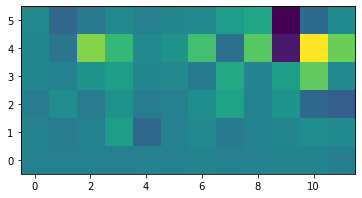

In [209]:
plt.imshow(model.encoder(batch_data).detach()[0, 0], origin="lower")

In [210]:
reconstruction.detach().numpy()[0, 0, :, :]

array([[-0.09249314, -0.08164486, -0.07220453, ..., -0.08255496,
        -0.06590098, -0.07034569],
       [-0.10450181, -0.10142358, -0.06859981, ..., -0.10150366,
        -0.07490378, -0.10470852],
       [-0.09897601, -0.05859922, -0.08234686, ..., -0.06105911,
        -0.07506208, -0.07956956],
       ...,
       [-0.10051902, -0.05713172, -0.07536807, ..., -0.05678802,
        -0.07531804, -0.07884668],
       [-0.10981163, -0.06532136, -0.08441961, ..., -0.06404481,
        -0.08394633, -0.0657161 ],
       [-0.09249377, -0.08164144, -0.0713938 , ..., -0.08267926,
        -0.06628802, -0.0706246 ]], dtype=float32)

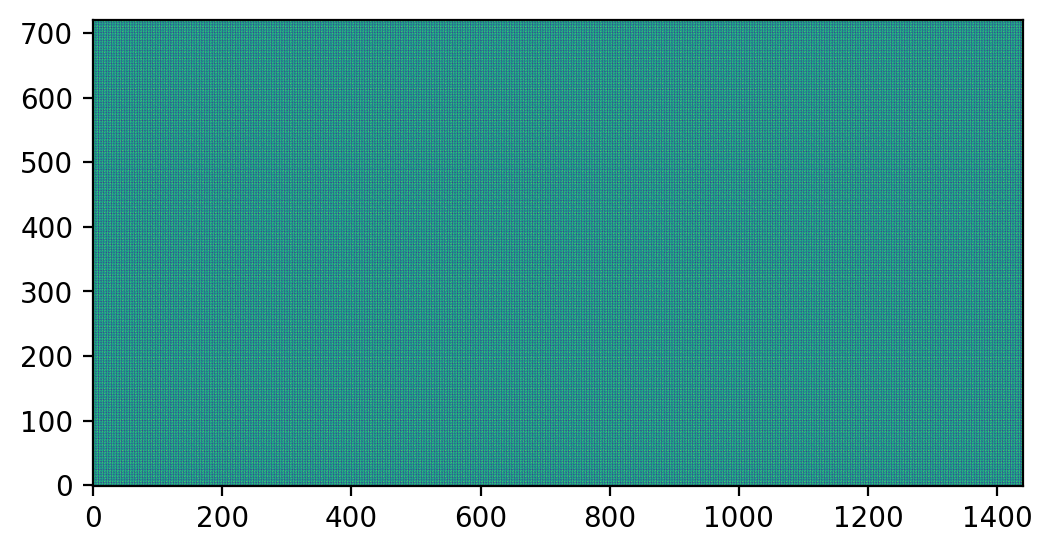

In [211]:
plt.figure(dpi=200)
plt.imshow(reconstruction.detach().numpy()[0, 0, :, :], origin="lower")

In [ ]:
import torch
from torch import nn
from dpk import model_objs


class ConvAutoEncoder(torch.nn.Module):
    
    def __init__(self, bottleneck_chans=8):
        
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=2, kernel_size=4, stride=4, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=2, out_channels=3, kernel_size=4, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=4, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=4, out_channels=bottleneck_chans, kernel_size=4, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh()
        )
                                    
        self.decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=bottleneck_chans, out_channels=8, kernel_size=4, stride=3, padding=2),
                                    nn.Tanh(),
                                    nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=4, padding=2),
                                    nn.Tanh(),
                                    nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=4, stride=4, padding=2),
                                    nn.Tanh(),
                                    nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=4, stride=4, padding=2),
                                    nn.Tanh()
        )

    def forward(self, data):
        encoding = self.encoder(data)
        return self.decoder(encoding)

import xarray as xr

def get_data(path):
    data = xr.open_dataset(path)
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    darr = torch.tensor(darr)[:, None, :, :]  # shape (t, 1 chan, w, h)
    # darr = torch.transpose(torch.transpose(darr, dim0=0, dim1=2), dim0=0, dim1=1)[None, :, :, :]  # shape (1, w, h, t)
    
    return torch.log(darr + 1e-30)

    
from torch.optim import Adam

data = get_data(r"./data/NO2_" + "2018-01-31" + ".nc4") # 3d tensor of snapshots
plt.imshow(data[0, 0, :, :], origin="lower")
# reproducibility
seed = 633

print("[ Using Seed : ", seed, " ]")

import torch
import random
import numpy as np
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

batch_size = 8
lr = 1e-5
wd = 1e-5

model = ConvAutoEncoder(bottleneck_chans=16)
opt = Adam(model.parameters(), lr=lr, weight_decay=wd)
epochs = 0
for i in range(500):
    for batch in range(data.shape[0] // batch_size):
        opt.zero_grad()
        batch_data = data[batch_size * batch:batch_size * (batch + 1)]
        reconstruction = model(batch_data)[:, :, 50:771, 100:1540]
        error = torch.sum((reconstruction - batch_data) ** 2)
        error.backward()
        opt.step()
    epochs += 1
model(batch_data).shape, batch_data.shape, model.encoder(batch_data)

# data = data.cuda()
# model = model.cuda()
# model = ConvAutoEncoder(bottleneck_chans=16)
# param_str = f"ConvAutoEncoder_{batch_size}_{epochs}_{seed}_{wd}_{lrt}"
# model.load_state_dict(torch.load(f"./forecasts/model_{param_str}.pt"))
# torch.save(model.state_dict(), f"./forecasts/model_{param_str}.pt")